## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `/input/AMSR2_sea_ice/`.


In [1]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/mn/vann/franzihe/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Figures/ERA5/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/Figures/ERA5/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    # FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')

sys.path.append(UTILS_DIR)
# make figure directory
# try:
#     os.mkdir(FIG_DIR)
# except OSError:
#     pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings



In [2]:
# import packages
from imports import(xr, intake, ccrs, cy, plt, glob, cm, fct, np, da, LogNorm, pd)
xr.set_options(display_style='html')

In [3]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open AMSR2 sea ice variable
downloaded: https://seaice.uni-bremen.de/data-archive/

data availability statement: The sea ice concentration data is from the Institute of Environmental Physics (IUP), University of Bremen, based on the ARTIST Sea Ice (ASI) algorithm (Spreen et al., 2008). The daily data sets (Melsheimer & Spreen, 2019a, 2019b, 2020a, 2020b) were downloaded for the years 2006–2017 from the data publisher PANGAEA.


In [5]:
amsr_in = os.path.join(INPUT_DATA_DIR, 'AMSR2_sea_ice/')
# era_out = os.path.join(INPUT_DATA_DIR, 'ERA5/common_grid/')
# make output data directory
# try:
#     os.mkdir(era_out)
# except OSError:
#     pass

In [4]:
starty = 2007
endy = 2010
year_range = range(starty, endy + 1)

In [7]:
hemisphere = ['s', 'n']


In [8]:
sic_all = {}
for hemi in hemisphere:
    print(hemi)
    # Pre-calculate lon and lat
    ds_grid = xr.open_dataset(glob(os.path.join(amsr_in,f'LongitudeLatitudeGrid-{hemi}6250-*.hdf'))[0], engine='netcdf4')
    lon = ds_grid.Longitudes.data
    lat = ds_grid.Latitudes.data

    # Initialize the dataset
    sic_all[hemi] = xr.Dataset()
    sic_all[hemi] = xr.Dataset()
    # sic_year = dict()
    # Iterate over years
    for year in range(starty, endy + 1):
        sic_year = xr.Dataset()

        # Iterate over months
        for month in [f'{m:02d}' for m in range(1, 13)]:
            # Collect files for the month
            files = sorted(glob(os.path.join(amsr_in, f'{year}/asi*{hemi}6250-{year}{month}*-v5.4.nc')))

            # Initialize dataset for the month
            sic_month = xr.Dataset()
            for f in files[:]:
                year = f[-16:-12]
                month = f[-12:-10]
                day = f[-10:-8]
                
                # print(year, month, day)
                ds = xr.open_dataset(f)
                # add time dimension
                ds = ds.expand_dims(time=pd.to_datetime([f'{year}-{month}-{day}']))
                
                # merge all to one xarray dataset
                sic_month = xr.merge([sic_month, ds])
            # sic_month = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True)

            # Merge month dataset to year dataset
            sic_year = xr.merge([sic_year, sic_month], )

        # Merge year dataset to the overall dataset
        sic_all[hemi] = xr.merge([sic_all[hemi], sic_year], )

    # Assign coordinates and drop unnecessary variables
    sic_all[hemi] = sic_all[hemi].assign_coords({"lon": (["y", "x"], lon),"lat": (["y", "x"], lat)}).drop_vars(["x", "y", "polar_stereographic"])

    sic_all[hemi]['z_season_mean'] = sic_all[hemi]['z'].groupby('time.season').mean('time', skipna=True)
    sic_all[hemi]['z_year_mean'] = sic_all[hemi]['z'].groupby('time.year').mean('time', skipna=True)
    sic_all[hemi]['z_month_mean'] = sic_all[hemi]['z'].groupby('time.month').mean('time', skipna=True)



s


n


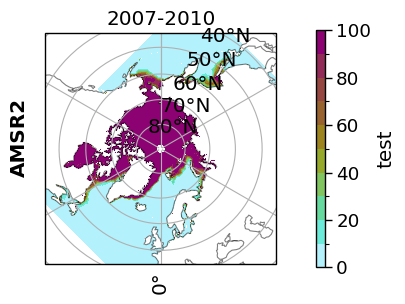

In [11]:
hemisphere = 'NH'
lat_extent = 45.

value = sic_all[hemi]['z_month_mean'].sel(month=1)
# hemi_glob = ratios.sel(threshold=lwp_threshold)['FoS_year_mean'].sel(model='ERA5', )
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=1, 
                            ncols=1, 
                            subplot_kw={'projection': projection}, 
                            figsize=[4, 3], sharex=True, sharey=True)

fct.setup_axes(axsm, hemisphere, lat_extent)
cmap = cm.hawaii_r
levels = np.arange(0,110,10)
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
axsm.text(-0.07, 0.55, 'AMSR2', 
                va='bottom', 
                ha='center', 
                rotation='vertical', 
                rotation_mode='anchor', 
                transform=axsm.transAxes, 
                fontweight='bold')

val = value#.sel(lat=slice(45,90)) if hemisphere == 'NH' else value.sel(lat=slice(-90,-45))
cf = axsm.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
# fct.add_text_box(axsm, hemi_glob.sel(hemisphere=hemisphere,), 'FoS')
axsm.set_title('2007-2010')

cbaxes = f.add_axes([0.9, 0.1, 0.0225, 0.79])
# cb_label = dict_label['FoS']['cb_label']
extend = None
plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label='test')

# ratios.sel(threshold=lwp_threshold)['FoS_year'].sel(model='ERA5').plot()

## Regrid AMSR2 data to common CMIP6 model grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) for the CMIP6 models in comparison to ERA5. 

The AMSR2 data has a different resolution and has to be regridded to the same horizontal resolution as the CMIP6 model. Hence we will make use of the python package `xesmf` and [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings).  

$\rightarrow$ Define CMIP6 model as the reference grid `ds_out`.

Save all variables in one file and each variable to a `netcdf` datasets between 2007 an 2010, locally.

> **_NOTE:_** This can take a while, so be patient



In [12]:
# needed for regridding ERA5 data to CMIP6 grids
cmip_in = os.path.join(INPUT_DATA_DIR, 'cmip6_hist/single_model')


model = 'IPSL-CM6A-LR'
variable_id = ['areacella']
cmip_file_in = glob(f'{cmip_in}/{model}/{variable_id[0]}_fx_*{model}*.nc')

ds_cmip = xr.open_mfdataset(cmip_file_in)

# Shift longitude to be from -180 to 180
ds_cmip = ds_cmip.assign_coords(lon=(((ds_cmip['lon'] + 180) % 360) - 180)).sortby('lon')
SH = ds_cmip.sel(lat=slice(-90,-40))
NH = ds_cmip.sel(lat=slice(40,90))
ds_cmip = xr.concat([SH, NH], 'lat')


# Regrid data
SH = fct.regrid_data(sic_all['s'], ds_cmip.sel(lat=slice(-90,-40)))
NH = fct.regrid_data(sic_all['n'], ds_cmip.sel(lat=slice(40,90)))


in_grid = xr.concat([SH, NH], 'lat')
            


z True
z_season_mean True
z_year_mean True
z_month_mean True
z True
z_season_mean True
z_year_mean True
z_month_mean True


In [18]:
filename = f'AMSR2_{model}_{starty}01_{endy}12.nc'
    
file_out = os.path.join(amsr_in, f'40NS/{filename}')

if os.path.exists(file_out):
        in_grid.to_netcdf(file_out)
        print('file written: {}'.format(file_out))
        #     print(f'{era_file_out} is downloaded')
        #     counter += 1
        #     print(f'Have regridded in total: {counter} files')
else:
        in_grid.to_netcdf(file_out)
        print('file written: {}'.format(file_out))

file written: /mn/vann/franzihe/input/AMSR2_sea_ice/40NS/AMSR2_IPSL-CM6A-LR_200701_201012.nc


In [68]:
test = xr.open_dataset('/mn/vann/franzihe/input/AMSR2_sea_ice/40NS/AMSR2_IPSL-CM6A-LR_200701_201012.nc')

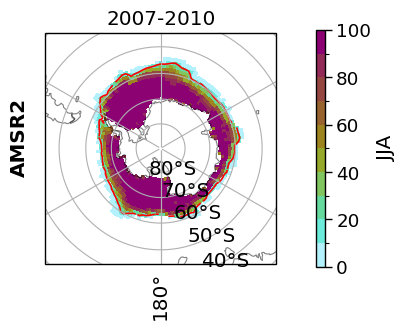

In [79]:
hemisphere = 'SH'
lat_extent = 45.

value = test['z_season_mean'].where(test['z_season_mean']>= 1.).sel(season='JJA')
# value = test['z_season_mean'].sel(season='JJA')

# hemi_glob = ratios.sel(threshold=lwp_threshold)['FoS_year_mean'].sel(model='ERA5', )
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=1, 
                            ncols=1, 
                            subplot_kw={'projection': projection}, 
                            figsize=[4, 3], sharex=True, sharey=True)

fct.setup_axes(axsm, hemisphere, lat_extent)
cmap = cm.hawaii_r
levels = np.arange(0,110,10)
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
axsm.text(-0.07, 0.55, 'AMSR2', 
                va='bottom', 
                ha='center', 
                rotation='vertical', 
                rotation_mode='anchor', 
                transform=axsm.transAxes, 
                fontweight='bold')

val = value#.sel(lat=slice(45,90)) if hemisphere == 'NH' else value.sel(lat=slice(-90,-45))
cf = axsm.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm, 
                            # vmin=20, vmax=20,
                            )
contour = val.plot.contour(ax=axsm, transform=ccrs.PlateCarree(), x='lon', y='lat', levels = [20., ], add_colorbar=False, colors = 'r')

axsm.set_title('2007-2010')

cbaxes = f.add_axes([0.9, 0.1, 0.0225, 0.79])
# cb_label = dict_label['FoS']['cb_label']
extend = None
cbar=plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label='JJA')

# ratios.sel(threshold=lwp_threshold)['FoS_year'].sel(model='ERA5').plot()